In [1]:
# Import libraries
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, exp
from pandas_datareader.data import DataReader
import requests_cache
%matplotlib inline

In [2]:
# Download data from pandas datareader -> AAPL.O, IBM.N, GOOG.O, BP.N, XOM.N, COST.O, GS.N
# Start: 01/01/2016
# End: 31/12/2016
# Create a dictionary: Key -> Ticker, Value -> Historical data from Start_Date to End_Date

session = requests_cache.CachedSession(cache_name='cache',backend='sqlite')
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_data(tickers, start_date="2015-01-01", end_date="2016-12-31"):
    stocks = dict()
    for ticker in tickers:
        s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
        s.insert(0, "Ticker", ticker)
        s['Prev Close'] = s['Adj Close'].shift(1)
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
        s['perc_return'] = (s['Adj Close']/s['Prev Close']) - 1
        stocks[ticker] = s
    return stocks

# Initialize the dataset with historical data
stocks = ["AAPL", "IBM", "GOOG", "BP", "XOM", "COST", "GS"]
portfolio = get_data(stocks)

## Question 4a. Using historical daily returns, calculate VaR95% and CVaR95% of portfolio as of 2016/12/31
### Calculate log return of portfolio by multiplying the weights with the log_returns of individual stocks each day
### Find the 5th Percentile worst log_return which is the 95% VaR

In [3]:
# Set weights of stocks in portfolio — ["AAPL", "IBM", "GOOG", "BP", "XOM", "COST", "GS"]
weights = np.array([0.15, 0.2, 0.2, 0.15,0.1,0.15,0.05])
shares_weights = {"AAPL": 0.15, "IBM": 0.2, "GOOG": 0.2, "BP": 0.15, "XOM": 0.1, "COST": 0.15, "GS": 0.05}
# Create column "Previous Adj Close" by shifting "Adj Close" down 1
# Calculate percentage returns by taking (Adj Close / Previous Adj Close) - 1

for stock in stocks:
    portfolio[stock]['Previous Adj Close'] = portfolio[stock]['Adj Close'].shift(1)
    portfolio[stock]['Perc_return'] = (portfolio[stock]['Adj Close'] / portfolio[stock]['Previous Adj Close']) - 1

# Drop na rows, in this case, 2015-12-31 entry

'''portfolio['AAPL'] = portfolio['AAPL'].dropna()
portfolio['IBM'] = portfolio['IBM'].dropna()
portfolio['GOOG'] = portfolio['GOOG'].dropna()
portfolio['BP'] = portfolio['BP'].dropna()
portfolio['XOM'] = portfolio['XOM'].dropna()
portfolio['COST'] = portfolio['COST'].dropna()
portfolio['GS'] = portfolio['GS'].dropna()'''


portfolio['AAPL'].head(10) # 2016-12-31 is a Saturday (non-trading day)

,Ticker,High,Low,Open,Close,Volume,Adj Close,Prev Close,log_return,perc_return,Previous Adj Close,Perc_return
Date,,,,,,,,,,,,
2014-12-31,AAPL,28.282499,27.552500,28.205000,27.594999,165613600.0,25.020117,NaN,NaN,NaN,NaN,NaN
2015-01-02,AAPL,27.860001,26.837500,27.847500,27.332500,212818400.0,24.782112,25.020117,-0.009558,-0.009513,25.020117,-0.009513
2015-01-05,AAPL,27.162500,26.352501,27.072500,26.562500,257142000.0,24.083961,24.782112,-0.028576,-0.028172,24.782112,-0.028172
2015-01-06,AAPL,26.857500,26.157499,26.635000,26.565001,263188400.0,24.086226,24.083961,0.000094,0.000094,24.083961,0.000094
2015-01-07,AAPL,27.049999,26.674999,26.799999,26.937500,160423600.0,24.423967,24.086226,0.013925,0.014022,24.086226,0.014022
2015-01-08,AAPL,28.037500,27.174999,27.307501,27.972500,237458000.0,25.362392,24.423967,0.037703,0.038422,24.423967,0.038422
2015-01-09,AAPL,28.312500,27.552500,28.167500,28.002501,214798000.0,25.389593,25.362392,0.001072,0.001072,25.362392,0.001072
2015-01-12,AAPL,28.157499,27.200001,28.150000,27.312500,198603200.0,24.763971,25.389593,-0.024950,-0.024641,25.389593,-0.024641
2015-01-13,AAPL,28.200001,27.227501,27.857500,27.555000,268367600.0,24.983849,24.763971,0.008840,0.008879,24.763971,0.008879


In [4]:
# Create a portfolio dataframe to store perc_return, log_return
portfolio_df = pd.DataFrame()
portfolio_df.insert(0, "Date", portfolio['AAPL'].index)
portfolio_df = portfolio_df.set_index("Date")
portfolio_df


""
Date
2014-12-31
2015-01-02
2015-01-05
2015-01-06
2015-01-07
...
2016-12-23
2016-12-27
2016-12-28


In [5]:
portfolio_df['Portfolio_perc_return'] = np.sum(portfolio[ticker]['Perc_return'] * shares_weights[ticker] for ticker in stocks)
portfolio_df['Portfolio_log_return'] = np.log(portfolio_df['Portfolio_perc_return'] + 1)
portfolio_df.head(10)

/var/folders/ft/1vxgzq515dlbjvpj_hhvgx0c0000gn/T/ipykernel_49057/240526439.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  portfolio_df['Portfolio_perc_return'] = np.sum(portfolio[ticker]['Perc_return'] * shares_weights[ticker] for ticker in stocks)


,Portfolio_perc_return,Portfolio_log_return
Date,,
2014-12-31,NaN,NaN
2015-01-02,0.000401,0.000401
2015-01-05,-0.025493,-0.025824
2015-01-06,-0.009617,-0.009664
2015-01-07,0.005201,0.005187
2015-01-08,0.017875,0.017717
2015-01-09,-0.005387,-0.005402
2015-01-12,-0.014052,-0.014152
2015-01-13,0.000996,0.000996


In [6]:
def var_HS(date, alpha, df):
    idx = df.index.get_loc(date)
    var = df.iloc[idx-249:idx+1]['Portfolio_log_return'].quantile(alpha) # Get the alpha quantile, that will be your VaR alpha% 
    return -1 * var # Return log VaR

In [7]:
dates = pd.date_range('2016-01-01', '2016-12-31')
portfolio_df['1_day_log_var95'] = np.nan # initialise column
for date in dates:
    try:
        portfolio_df.loc[date, '1_day_log_var95'] = var_HS(date, 0.05, portfolio_df)
    except KeyError:
        pass
portfolio_df['2016-01-01':'2016-12-31']

,Portfolio_perc_return,Portfolio_log_return,1_day_log_var95
Date,,,
2016-01-04,-0.011056,-0.011117,0.015922
2016-01-05,-0.003976,-0.003984,0.015922
2016-01-06,-0.010153,-0.010205,0.015922
2016-01-07,-0.025263,-0.025588,0.016127
2016-01-08,-0.011843,-0.011914,0.016127
...,...,...,...
2016-12-23,-0.000006,-0.000006,0.014453
2016-12-27,0.002387,0.002384,0.014453
2016-12-28,-0.004500,-0.004510,0.014453


In [8]:
last_day_log_var = portfolio_df['1_day_log_var95'].iloc[-1]
last_day_simple_var = np.exp(last_day_log_var) - 1

print(f"VaR95% of portfolio as of 2016/12/31 is {last_day_log_var} log return loss or {last_day_simple_var} simple return loss for 95% confidence")

VaR95% of portfolio as of 2016/12/31 is 0.01445269661722914 log return loss or 0.014557641807815047 simple return loss for 95% confidence


## Q4ai. The VaR95% of portfolio as of 2016/12/31 is 0.01445269661722914 (14.45%) log return loss or 0.014557641807815047 (14.56%) simple return loss for 95% confidence.

### To find the CVaR95% or expected shortfall at 95% using Historical Data:
### 1. Sort the log returns
### 2. Find the alpha-th cut off i.e 5% of 100 day window => Cut-off at 5th lowest returns as Expected Shortfall or CVaR95%
### 3. Sum from 1st to alpha-th returns. Then divide by the entire window period


In [9]:
import math 
def ES_HS(date, alpha, df):
    idx = df.index.get_loc(date)
    log_return = df.iloc[idx - 249:idx + 1]['Portfolio_log_return']
    log_return_sorted = sorted(log_return)
    length = len(log_return_sorted)
    cut_off_index = math.floor(length * alpha + 1) - 1

    below_var = log_return_sorted[:cut_off_index]
    sum_loss = sum(below_var)
    len_loss = len(below_var)

    return -1* (sum_loss / len_loss)

In [12]:
from copy import deepcopy

for d in dates:
    try:
        portfolio_df.loc[d, '1_day_log_ES95'] = ES_HS(d, 0.05, portfolio_df)
    except KeyError:
        pass
    
last_day_ES_log = portfolio_df.iloc[-1]['1_day_log_ES95']
last_day_ES_simple = np.exp(last_day_ES_log) - 1
print(f"The CVaR95% of portfolio as of 2016/12/31 is {last_day_ES_log} or {last_day_ES_simple}")

The CVaR95% of portfolio as of 2016/12/31 is 0.022023432614405272 or 0.02226773859552078


## Q4aii. The CVaR95% or Expected Shortfall of portfolio as of 2016/12/31 is 2.202% log return loss or 2.227% simple return loss for 95% confidence.
---

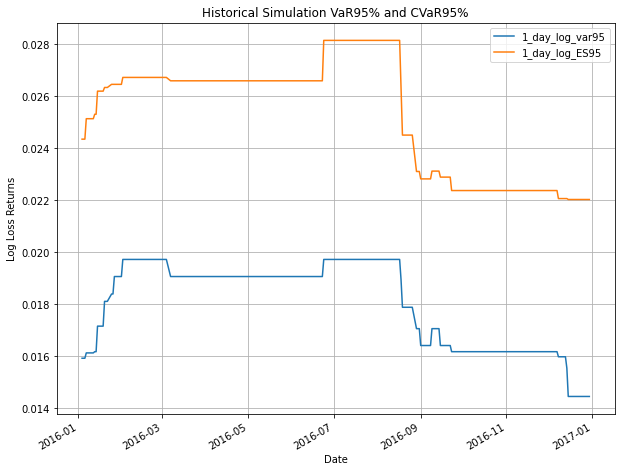

In [93]:
plt.figure(figsize=(10,8))
plt.ylabel('Log Loss Returns')
plt.xlabel('Date')
plt.title('Historical Simulation VaR95% and CVaR95%')
portfolio_df["1_day_log_var95"].plot()
portfolio_df['1_day_log_ES95'].plot()
plt.legend()
plt.grid()

## Q4b. Calculate VaR95% and CVaR95% using parametric method
### Assumption: returns are normally distributed
### For each day -> Take the previous 250 trading days to calculate mean returns, variance co-variance matrix.
### We assume weights to stay the same (buy and hold)

In [84]:
for ticker in stocks:
    portfolio[ticker] = portfolio[ticker].rename(columns={'log_return': ticker+"_log_return"})

dfs = [portfolio[ticker][ticker+"_log_return"] for ticker in stocks]
stock_return = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
stock_return

,AAPL_log_return,IBM_log_return,GOOG_log_return,BP_log_return,XOM_log_return,COST_log_return,GS_log_return
Date,,,,,,,
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.009558,0.010046,-0.003025,0.000000,0.004102,-0.000988,0.002988
2015-01-05,-0.028576,-0.015860,-0.021066,-0.054446,-0.027743,-0.011434,-0.031720
2015-01-06,0.000094,-0.021802,-0.023450,-0.007508,-0.005330,0.013128,-0.020437
2015-01-07,0.013925,-0.006557,-0.001715,0.002509,0.010081,0.017263,0.014793
...,...,...,...,...,...,...,...
2016-12-23,0.001976,-0.002097,-0.001708,0.002976,-0.001762,0.000062,0.003534
2016-12-27,0.006331,0.002576,0.002074,0.002428,0.000441,-0.000185,0.002445
2016-12-28,-0.004273,-0.005700,-0.008246,0.003765,-0.004971,-0.006438,-0.003774


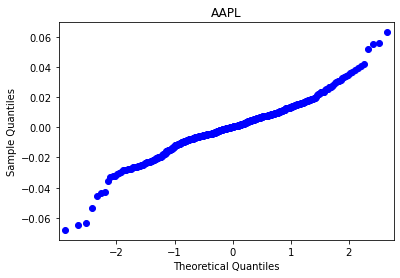

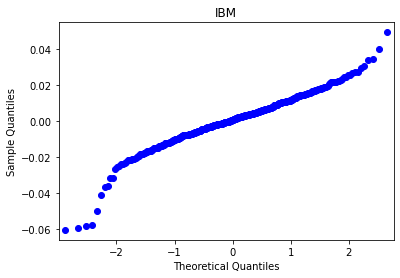

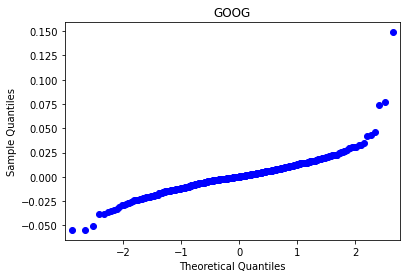

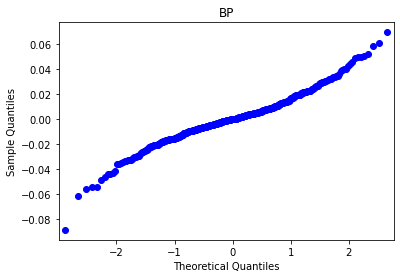

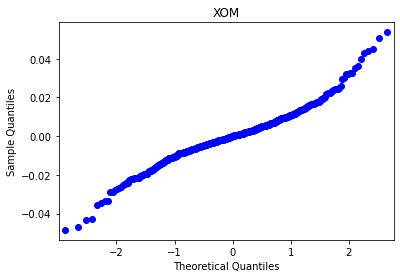

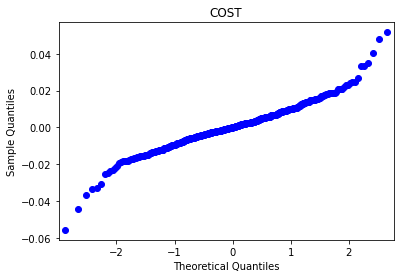

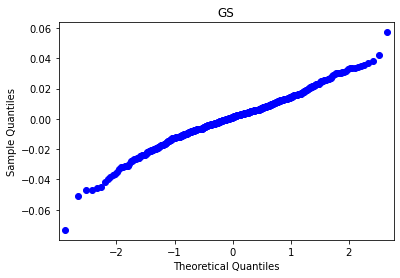

In [85]:
# QQ Plot to check for normality in log_return
# All closely scattered on the diagonal line with a few deviations
# Especially at the ends which deviates relatively more from the diagonal line
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings('ignore')

qqplot(stock_return['AAPL_log_return'], line='s')
plt.title('AAPL')
qqplot(stock_return['IBM_log_return'], line='s')
plt.title('IBM')
qqplot(stock_return['GOOG_log_return'], line='s')
plt.title('GOOG')
qqplot(stock_return['BP_log_return'], line='s')
plt.title('BP')
qqplot(stock_return['XOM_log_return'], line='s')
plt.title('XOM')
qqplot(stock_return['COST_log_return'], line='s')
plt.title('COST')
qqplot(stock_return['GS_log_return'], line='s')
plt.title('GS')

plt.show()


In [163]:
from scipy.stats import norm 
def var_parametric(date, significance_level, df, weights):
    idx = df.index.get_loc(date)

    mean_stock_return = df.iloc[idx-249: idx+1][['AAPL_log_return', 'IBM_log_return', 'GOOG_log_return', 'BP_log_return', 'XOM_log_return', 'COST_log_return', 'GS_log_return']].mean()
    returns = np.exp(mean_stock_return.values) - 1
    mean_return = np.dot(weights, returns)
    mean_log_return = np.log(mean_return + 1)
    weighted_mean = mean_log_return
    
    # print(f"weighted mean: {weighted_mean}")
    mat_df = df.iloc[idx-249: idx+1][['AAPL_log_return', 'IBM_log_return', 'GOOG_log_return', 'BP_log_return', 'XOM_log_return', 'COST_log_return', 'GS_log_return']].values
    vcv = np.cov(mat_df.T)
    vcv_perc = np.exp(vcv) - 1
    variance_perc = np.dot(weights, np.dot(vcv_perc, weights))
    variance = np.log(variance_perc + 1)
    #print(f"variance: {variance}")

    volatility = sqrt(variance)
    z_alpha = norm.ppf(significance_level, loc = 0, scale = 1)
    #print(z_alpha)
    VaR_portfolio = weighted_mean + volatility * z_alpha
    # print(VaR_portfolio)
    return - 1 * VaR_portfolio

In [164]:
for d in dates:
    try:
        portfolio_df.loc[d, '1_day_parametric_log_var95'] = var_parametric(d, 0.05, stock_return, weights)
    except KeyError:
        pass

In [165]:
portfolio_df.iloc[-1]['1_day_parametric_log_var95']

0.01432576500868773

## Q4bi. The VaR95% of portfolio using Parametric method as of 2016/12/31 1.44% log return loss for 95% confidence.

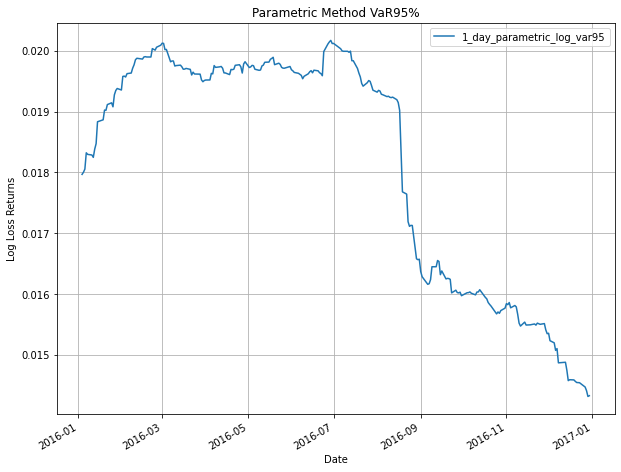

In [226]:
plt.figure(figsize=(10,8))
plt.ylabel('Log Loss Returns')
plt.xlabel('Date')
plt.title('Parametric Method VaR95%')
portfolio_df['2016-01-01':]['1_day_parametric_log_var95'].plot()
plt.legend()
plt.grid()

## Parametric CVaR95% or Parametric Expected Shortfall:
$$ ES^P_{t} = \sigma_{PF, t} * \frac{\varphi(\Phi^{-1}_{p})}{p}$$
### where p = alpha (1-confidence level)

In [188]:
def CVaR_Parametric(date, significance_level, df, weights):
    idx = df.index.get_loc(date)

    mean_stock_return = df.iloc[idx-249: idx+1][['AAPL_log_return', 'IBM_log_return', 'GOOG_log_return', 'BP_log_return', 'XOM_log_return', 'COST_log_return', 'GS_log_return']].mean()
    returns = np.exp(mean_stock_return.values) - 1
    mean_return = np.dot(weights, returns)
    mean_log_return = np.log(mean_return + 1)
    mu = mean_log_return
   # print(f"weighted: {mu}")
    
    mat_df = df.iloc[idx-249: idx+1][['AAPL_log_return', 'IBM_log_return', 'GOOG_log_return', 'BP_log_return', 'XOM_log_return', 'COST_log_return', 'GS_log_return']].values
    vcv = np.cov(mat_df.T)
    vcv_perc = np.exp(vcv) - 1
    variance_perc = np.dot(weights, np.dot(vcv_perc, weights))
    variance = np.log(variance_perc + 1)
    
    sigma = sqrt(variance)
 
    return mu + (sigma * norm.pdf(norm.ppf(1-significance_level, loc=0, scale=1), loc=0, scale=1)/(significance_level))


In [194]:
for date in dates:
    try:
        portfolio_df.loc[date, '1_day_parametric_log_CVaR95'] = CVaR_Parametric(date, 0.05, stock_return, weights)
    except KeyError:
        pass
last_day_log_CVaR95 = portfolio_df.iloc[-1]['1_day_parametric_log_CVaR95']
last_day_simple_CVaR95 = np.exp(last_day_log_CVaR95) - 1
print(f"CVaR95% or Expected Shortfall calculated using Parametric method is {last_day_log_CVaR95} log return loss or {last_day_simple_CVaR95} simple return loss for 95% confidnece")

CVaR95% or Expected Shortfall calculated using Parametric method is 0.019343246271617837 log return loss or 0.019531538964240536 simple return loss for 95% confidnece


## Q4bii. The CVaR95% or Expected Shortfall calculated using Parametric method is 19.34% log return loss or 19.53% simple return loss for 95% confidence.
---

No handles with labels found to put in legend.


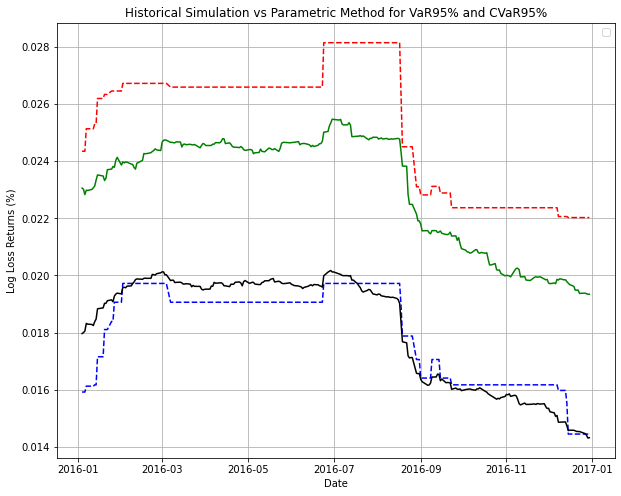

In [203]:
plt.figure(figsize=(10,8))
plt.ylabel('Log Loss Returns (%)')
plt.xlabel('Date')
plt.title('Historical Simulation vs Parametric Method for VaR95% and CVaR95%')
plt.plot(portfolio_df["1_day_log_var95"], 'b--')

plt.plot(portfolio_df['1_day_log_ES95'], 'r--')
plt.plot(portfolio_df['1_day_parametric_log_CVaR95'], 'g')
plt.plot(portfolio_df['2016-01-01':]['1_day_parametric_log_var95'],'k')
plt.legend()
plt.grid()

## Q4c. Rebalance portfolio monthly, what is the optimal portfolio holding by end of each month till end of 2016.

### Basic EDA
### Visualise asset correlation, returns series, annualized volatility and annualized Sharpe Ratio for each stock

Text(0.5, 1.0, 'Asset Correlations')

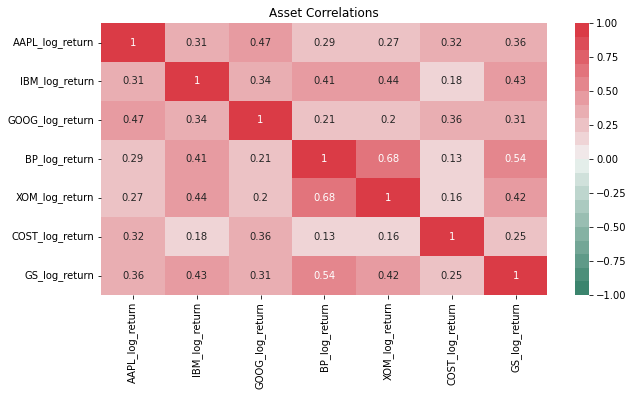

In [227]:
import seaborn as sns

# Returns correlation - we only consider 2016
returns_df = deepcopy(stock_return.loc['2016-01-01':'2016-12-31'])
plt.figure(figsize=(10,5))
sns.heatmap(round(returns_df.corr(), 2), cmap = sns.diverging_palette(160,10,n=20), annot=True, vmin = -1, vmax=1)
plt.title("Asset Correlations")

### We observe that all goods are positively correlated to each other. Note that Costco-IBM, Costco-BP and Costco-Exxon are the least correlated.

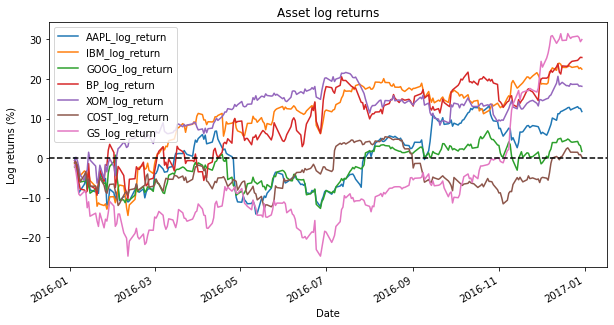

In [228]:
# Cumulative Returns
# Convert returns to % and plot the returns series for all stocks
returns_df.expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (10,5))
plt.title("Asset log returns")
plt.ylabel("Log returns (%)")
plt.axhline(y=0, color="black", linestyle="--")

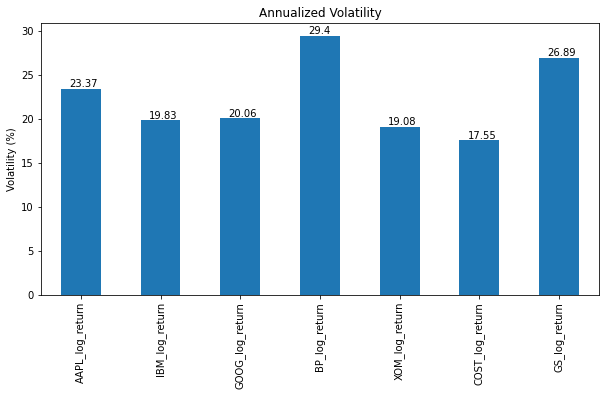

In [229]:
# Annualized Volatility
ax = round(returns_df.std() * len(returns_df.index) ** 0.5 * 100, 2).plot(figsize = (10,5), kind="bar")
plt.title("Annualized Volatility")
plt.ylabel("Volatility (%)")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()+0.2))

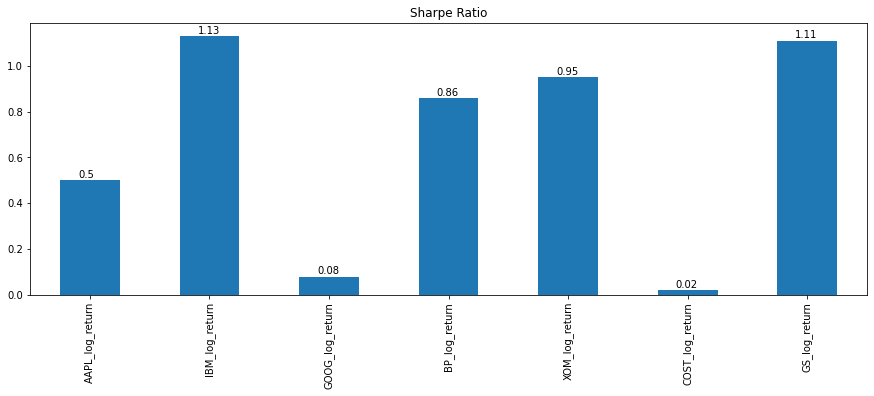

In [230]:
# Annualized Sharpe Ratio
ax = round(returns_df.mean(axis=0)/returns_df.std(axis=0) * len(returns_df.index) ** 0.5,2).plot(kind='bar', figsize=(15,5))
plt.title("Sharpe Ratio")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.15, p.get_height()+0.01))

### IBM and GS carries good Sharpe Ratio of 1.13 and 1.11 respectively as compared to the other stocks which brings <1 Sharpe Ratio.

## Portfolio Optimization
### Assumptions:
- Shorting allowed
- No leverage (Sum of weights = 1)
- No transaction fees
- Objective Function: Minimize Risk and Maximize Returns

### Find the optimal portfolio which we define as the highest Sharpe ratio (Minimize Variance and Maximize returns) across 4 different strategies 
1. Long-only with constraint (single stock <= 50% of portfolio)
2. Long-only without constraint
3. Long-short with constraint
4. Long-short without constraint

### Potential issues to take note:
1. Overexposure to single stock is risky (single stock <= 50% of portfolio)
2. We are ignoring transaction fees for rebalancing portfolio
3. We can also consider only minimizing risk (variance) only

In [220]:
# import packages: cvxpy, cvxopt
# Please uncomment line below to install package.
# !pip install cvxpy --upgrade
# !pip install cvxopt

import cvxpy as cvx

In [221]:
# Monthly rebalancing, create function to calculate monthly simple returns
def monthlySimpleReturns(returns_df, month):
    month_df = returns_df[returns_df.index.month == month]
    col_names = dict()
    for col in returns_df.columns:
        col_names[col] = col.split(" ")[0]
    month_df = month_df.rename(columns=col_names)
    return np.exp(month_df) - 1
simple_returns = monthlySimpleReturns(returns_df, 1)
simple_returns.head(5)


,AAPL_log_return,IBM_log_return,GOOG_log_return,BP_log_return,XOM_log_return,COST_log_return,GS_log_return
Date,,,,,,,
2016-01-04,0.000855,-0.012135,-0.022454,-0.006398,-0.006286,-0.012137,-0.017145
2016-01-05,-0.025059,-0.000736,0.000998,-0.004185,0.008521,0.002445,-0.017218
2016-01-06,-0.019570,-0.005006,0.001400,-0.020369,-0.008321,-0.009254,-0.024413
2016-01-07,-0.042205,-0.017090,-0.023170,-0.028713,-0.016006,-0.022909,-0.030735
2016-01-08,0.005288,-0.009257,-0.016410,-0.017669,-0.020202,-0.017504,-0.004131


In [222]:
'''
    Returns_scale can be adjusted to place more emphasis on returns
    Max_holdings set at 50% by default. Can be set to 1 (100%)
    Long_only set as True by default. Can be set to False to allow for Long-short
'''
def optimizePortfolio(returns_df, long_only = True, returns_scale = 0.0001, max_holding = 0.5):
    returns = returns_df.T.to_numpy()
    m = returns.shape[0]
    cov = np.cov(returns)
    x = cvx.Variable(m)

    portfolio_variance = cvx.quad_form(x, cov)
    log_returns_df = np.log(returns_df + 1)
    total_returns_log = log_returns_df.sum().to_numpy()

    total_simple_return = np.exp(total_returns_log) -1
    horizon_length = returns.shape[1]
    expected_mean = (1+total_simple_return) ** (1 / horizon_length) -1

    portfolio_return = sum(cvx.multiply(expected_mean, x))

    # Objective function: Minimize variance and maximize returns.
    # If we want to place higher emphasis on returns, we can set the returns_scale higher.
    # If we only want to minimize risk, we can set returns_scale = 0
    objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)

    # Long only, sum weights = 1, no overexposure to single stock (<= 50% portfolio)
    if long_only:
        constraints = [x >= 0, sum(x) == 1, x <= max_holding]
    else:
        constraints = [x >= -1, x <=1, sum(x) == 1, x <= max_holding]
    problem = cvx.Problem(objective, constraints)
    result = problem.solve()
    return x.value

In [223]:
# Helper function to compute log_portfolio returns 
def computeLogReturns(simple_returns, weights):
    weighted_returns = simple_returns * weights
    portfolio_returns = np.sum(weighted_returns, axis = 1)
    log_returns = np.log(portfolio_returns + 1)
    return log_returns

In [224]:
# Iterate through each month, find the allocations for each strategy and its corresponding returns -> calculate Sharpe Ratio
# Get the highest Sharpe Ratio for the month and its corresponding strategy
# Print the allocation
for month in range(1,13):
    simple_returns = monthlySimpleReturns(returns_df, month)
    trading_days = len(simple_returns.index)
    portfolios = dict()
    allocations = dict()
    returns = dict()

    # Long-only portfolio with <=50% constraint
    month_long = optimizePortfolio(simple_returns)
    month_long_returns = computeLogReturns(simple_returns, month_long)
    sharpe_long = round(month_long_returns.mean(axis=0)/month_long_returns.std(axis=0) * trading_days ** 0.5,2) # Annualized Sharpe Ratio
    portfolios["Long_only"] = sharpe_long
    allocations['Long_only'] = month_long
    returns['Long_only'] = np.sum(month_long_returns)
    
    # Long-only unconstrained exposure
    month_long_unconstrained = optimizePortfolio(simple_returns, max_holding= 1)
    month_long_unconstrained_returns = computeLogReturns(simple_returns, month_long_unconstrained)
    sharpe_long_unconstrained = round(month_long_unconstrained_returns.mean(axis=0)/month_long_unconstrained_returns.std(axis=0) * trading_days ** 0.5,2) # Annualized Sharpe Ratio
    portfolios['Long_unconstrained'] = sharpe_long_unconstrained
    allocations['Long_unconstrained'] = month_long_unconstrained
    returns['Long_unconstrained'] = np.sum(month_long_unconstrained_returns)

    # Long-short with <=50% constraint
    month_long_short = optimizePortfolio(simple_returns, long_only = False)
    month_long_short_returns = computeLogReturns(simple_returns, month_long_short)
    sharpe_long_short = round(month_long_short_returns.mean(axis=0)/month_long_short_returns.std(axis=0) * trading_days ** 0.5, 2) # Annualized Sharpe Ratio
    portfolios['Long_short'] = sharpe_long_short
    allocations['Long_short'] = month_long_short
    returns['Long_short'] = np.sum(month_long_short_returns)

    # Long-short unconstrained exposure
    month_long_short_unconstrained = optimizePortfolio(simple_returns, long_only = False)
    month_long_short_returns_unconstrained = computeLogReturns(simple_returns, month_long_short_unconstrained)
    sharpe_long_short_unconstrained = round(month_long_short_returns_unconstrained.mean(axis=0)/month_long_short_returns_unconstrained.std(axis=0) * trading_days ** 0.5, 2) # Annualized Sharpe Ratio   
    portfolios['Long_short_unconstrained'] = sharpe_long_short_unconstrained
    allocations['Long_short_unconstrained'] = month_long_short_unconstrained
    returns['Long_short_unconstrained'] = np.sum(month_long_short_returns_unconstrained)
    
    best_strategy = max(portfolios, key=portfolios.get)
    best_allocation = allocations[best_strategy]
    best_log_returns = returns[best_strategy]
    
    print(f"-------------------- Month {month} --------------------")
    print(f"Best Strategy: {best_strategy}")
    print(f"Sharpe Ratio: {portfolios[best_strategy]}")
    print(f"Log returns: {best_log_returns}\n")
    print(f"Portfolio Allocation:\n{round(pd.Series(best_allocation, index = simple_returns.columns),2)}\n")

    
''' ### If you want to see the portfolio allocations with its corresponding Sharpe Ratio for each strategy ###
    print(f"-------------------- Month: {month} --------------------")
    print("Long-only portfolio with constraint")
    print(f"Sharpe ratio: {sharpe_long}\n")
    print(f"Portfolio allocation:\n{round(pd.Series(month_long, index = simple_returns.columns),2)}\n")

    print("Long-only portfolio without constraint")
    print(f"Sharpe ratio: {sharpe_long_unconstrained}\n")
    print(f"Portfolio allocation:\n{round(pd.Series(month_long_unconstrained, index = simple_returns.columns),2)}\n")

    print("Long-short portfolio with constraint")
    print(f"Sharpe ratio: {sharpe_long_short}\n")
    print(f"Portfolio allocation:\n{round(pd.Series(month_long_short, index = simple_returns.columns),2)}\n")   

    print("Long-short portfolio without constraint")
    print(f"Sharpe ratio: {sharpe_long_short_unconstrained}\n")
    print(f"Portfolio allocation:\n{round(pd.Series(month_long_short_unconstrained, index = simple_returns.columns),2)}")
    print("--------------------------------------------------")''';




-------------------- Month 1 --------------------
Best Strategy: Long_unconstrained
Sharpe Ratio: -1.34
Log returns: -0.0788034996258534

Portfolio Allocation:
AAPL_log_return   -0.00
IBM_log_return     0.41
GOOG_log_return   -0.00
BP_log_return      0.00
XOM_log_return     0.00
COST_log_return    0.59
GS_log_return     -0.00
dtype: float64

-------------------- Month 2 --------------------
Best Strategy: Long_short
Sharpe Ratio: 0.08
Log returns: 0.002546132895282976

Portfolio Allocation:
AAPL_log_return   -0.13
IBM_log_return     0.07
GOOG_log_return    0.38
BP_log_return     -0.16
XOM_log_return     0.50
COST_log_return    0.18
GS_log_return      0.16
dtype: float64

-------------------- Month 3 --------------------
Best Strategy: Long_short
Sharpe Ratio: 3.26
Log returns: 0.07448788112483866

Portfolio Allocation:
AAPL_log_return    0.01
IBM_log_return     0.26
GOOG_log_return    0.01
BP_log_return     -0.09
XOM_log_return     0.33
COST_log_return    0.39
GS_log_return      0.09
d